In [1]:
# This code fits a Fourier spectrum to the SGS topography corresponding
# to a given lat,lon. The workflow is as follows: find the low-res ICON triangle
# whose centroid is closest to the given reference location, fetch the data within 
# this triangle, fit the linear-regression-based Fourier spectrum to it, and finally 
# plot the spectrum and the reconstructed topography along with the reference truth.
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy.ma as ma
from topoPy import *

vmin=-1500; vmax=1500

In [2]:
# ICON grid file
df = nc.Dataset('../data/icon_grid_0012_R02B04_G.nc')
# print(df.variables)

# store the lat,lon of the vertices and the centre of each triangular grid
clat = ma.getdata(df.variables['clat'][:])
clat_vertices = ma.getdata(df.variables['clat_vertices'][:])
clon = ma.getdata(df.variables['clon'][:])
clon_vertices = ma.getdata(df.variables['clon_vertices'][:])

# change to degrees
clat, clat_vertices = clat*(180/np.pi), clat_vertices*(180/np.pi)
clon, clon_vertices = clon*(180/np.pi), clon_vertices*(180/np.pi)

In [3]:
# pick the cell around the reference lat,lon
def pickCell(lat_ref, lon_ref, clat, clon):
    index = np.nonzero((np.abs(clat-lat_ref)<=1) & 
                       (np.abs(clon-lon_ref)<=1))[0]
    
    print("index = ", index)
    # pick the centre closest to the reference location
    dist = np.abs(clat[index]-lat_ref) + np.abs(clon[index]-lon_ref) 
    print("dist = ", dist)
    ind = np.argmin(dist)
    print("ind = ", ind)
    return index[ind]

In [4]:
# N_coor = -31.8894588
# E_coor = -70.6014078
N_coor = 45
E_coor = 45

print(np.argmin(clat - N_coor))
print(np.argmin(clon - E_coor))

17408
11272


In [5]:
#---- pick the ICON cell for a given reference location
lat_ref = 43
lon_ref = 42

# lat_ref = -32
# lon_ref = -71
# lat_ref, lon_ref = 28, 87 # Langtang National Park, Nepal
# lat_ref, lon_ref = 42,23 # Pirin National Park, Bulgaria
# lat_ref, lon_ref = 50,8 # Taunus
# lat_ref, lon_ref = 46,8 # Firehorn, Switzerland
vid = pickCell(lat_ref,lon_ref,clat,clon) # pick a vertex
print('Vertex ID:',vid)

#---- get the data for the picked cell
datfile = '../data/GMTED2010_topoGlobal_SGS_30ArcSec.nc'
var = {'name':'topo','units':'m'}
#---- set (lon,lat) of the centre of the grid
lon_centre = clon[vid]    # in degrees
lat_centre = clat[vid]    # in degrees
#---- set the periphery of the coarse grid around the centre 
lon_width = 4  # in degrees
lat_width = 4  # in degrees
#---- get the topography around the cell picked
%time lon,lat,z = fetch_data(datfile,var,lon_centre,lat_centre,lon_width,lat_width)

index =  [440]
dist =  [0.71705466]
ind =  0
Vertex ID: 440
{'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(nfiles, lat)
    units: degrees
unlimited dimensions: 
current shape = (108, 2400)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(nfiles, lon)
    units: degrees
unlimited dimensions: 
current shape = (108, 3600)
filling on, default _FillValue of 9.969209968386869e+36 used, 'topo': <class 'netCDF4._netCDF4.Variable'>
float32 topo(nfiles, lat, lon)
    units: meters
unlimited dimensions: 
current shape = (108, 2400, 3600)
filling on, default _FillValue of 9.969209968386869e+36 used}
n =  0
[]
n =  1
[]
n =  2
[]
n =  3
[]
n =  4
[]
n =  5
[]
n =  6
[]
n =  7
[]
n =  8
[]
n =  9
[]
n =  10
[]
n =  11
[]
n =  12
[]
n =  13
[]
n =  14
[]
n =  15
[]
n =  16
[]
n =  17
[]
n =  18
[]
n =  19
[]
n =  20
[]
n =  21
[]
n =  22
[]
n =  23
[]
n =  24
[]
n =  25
[]
n =  26
[4576837 4576838 4576839 ... 6301714 630171

#### Plot the topo and the ICON triangle

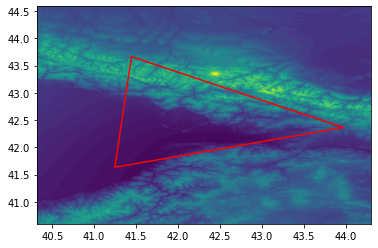

In [6]:
plt.contourf(lon,lat,z,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.show()

#### Plot the topo within the ICON triangle

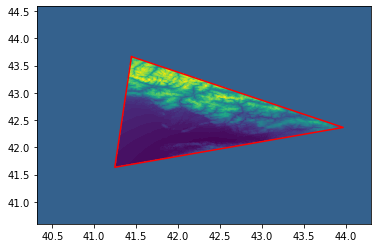

In [7]:
vi = clat_vertices[vid,:]
vj = clon_vertices[vid,:]
inout = [pointInTriangle(vi,vj,i,j) for i in lat for j in lon]
inout = np.array(inout).reshape(len(lat),len(lon))
z_masked = z*inout

plt.contourf(lon,lat,z_masked,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.show()

#### Test the error when we do not do a projection from the isocahedral triangular grid to a 2D Cartesian plane

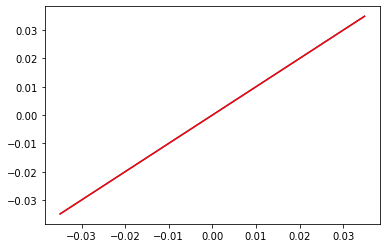

5.522835904773479e-05


In [8]:
tmin = -2.0 / 180 * np.pi
tmax = -tmin
trange = np.linspace(tmin, tmax, 100)
plt.figure()
plt.plot(trange , np.tan(trange))
plt.plot(trange, trange ,'r')
# plt.xlabel(trange, trange / np.pi * 180)
plt.show()

print(np.linalg.norm(np.tan(trange) - trange))

#### Lat-lon to X-Y Cartesian projection 

In [9]:
A = 6371.0008
A = 1.0

print(lat.min(), lat.max())
print(lon.min(), lon.max())

def ll_xy_projection(lat, lon, lat_c, lon_c):
    lat = lat / 180.0 * np.pi
    lon = lon / 180.0 * np.pi
    lat_c = lat_c / 180.0 * np.pi
    lon_c = lon_c / 180.0 * np.pi
    dlat = lat - lat_c
    dlon = lon - lon_c
    print("max(dlat, dlon) = ", dlat.max(), dlon.max())
    
    xp = A * np.cos(lat) * dlon
    yp = A * dlat
    
    return yp, xp

# ll_xy_projection(lat, lon, lat_centre, lon_centre)
lat_proj, lon_proj = ll_xy_projection(lat, lon, lat_centre, lon_centre)

print(lat_proj.min(), lat_proj.max())
print(lon_proj.min(), lon_proj.max())

40.59583282470703 44.587501525878906
40.3125 44.30416488647461
max(dlat, dlon) =  0.0347994596063933 0.03479263016776024
-0.03486830187786161 0.0347994596063933
-0.026481286612682696 0.02477858739290324


#### We test how the projection looks like.

max(dlat, dlon) =  0.018688542528885632 0.028926878293356606
[ 0.01868854 -0.0167556  -0.00399036] [-0.01093949 -0.0138997   0.02137312]


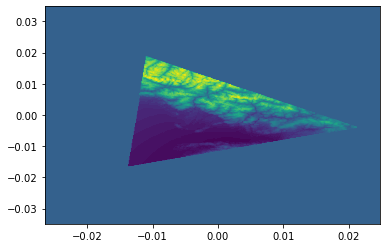

In [10]:
vi = clat_vertices[vid,:]
vj = clon_vertices[vid,:]

vip, vjp = ll_xy_projection(vi, vj, lat_centre, lon_centre)
print(vip, vjp)
inout = [pointInTriangle(vip,vjp,i,j) for i in lat_proj for j in lon_proj]
inout = np.array(inout).reshape(len(lat_proj),len(lon_proj))
z_masked_p = z*inout

plt.figure()
plt.contourf(lon_proj,lat_proj,z_masked_p,60)
x = np.append(vip,vip[0])
y = np.append(vjp,vjp[0])

# plt.plot(x,y,'-r')
plt.show()

#### Image moments function. 
Ref: https://en.wikipedia.org/wiki/Image_moment#Raw_moments

In [11]:
import imageio as misc

def raw_moment(data, i_order, j_order):
    nrows, ncols = data.shape
    y_indices, x_indicies = np.mgrid[:nrows, :ncols]
    return (data * x_indicies**i_order * y_indices**j_order).sum()

def moments_cov(data):
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_centroid = m10 / data_sum
    y_centroid = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_centroid * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_centroid * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_centroid * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])
    return cov

def get_pca(z_masked, plot_diag = False):
    img = np.copy(z_masked)
    imin = img.min()
    # img -= imin
    y, x = np.nonzero(img)

    xm = np.mean(x)
    ym = np.mean(y)

    x = x - xm
    y = y - ym
    coords = np.vstack([x, y])

    supp_img = np.copy(img)
    supp_img[np.where(img < 0.0)] = 0.0
    supp_img[np.where(img > 0.0)] = 1.0
    # supp_img[np.where(img > 0.0)] = img[inout][np.where(img[inout] > 0.0)].mean()
    # supp_img -= supp_img.min()
    cov = moments_cov(supp_img)
    evals, evecs = np.linalg.eig(cov)

    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    if plot_diag == True:
        scale = 30.0
        plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
        plt.plot([x_v1*-scale*2, x_v1*scale*2],
                 [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
                 [y_v2*-scale, y_v2*scale], color='blue')
        plt.axis('equal')
        plt.show()
    return x_v1, x_v2, y_v1, y_v2


In [12]:
import scipy 

def rotate_topo(x_v1, x_v2, y_v1, y_v2, img, theta = None, plot_diag = False, verbose = False):
    if theta is None:
        theta = -np.arctan((y_v1)/(x_v1))
        
    if verbose:
        print("theta in degrees:", np.around(theta / np.pi * 180,2))
        
    if np.abs(theta) == np.pi:
        theta -= 0.01
        
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta),0],
                              [np.sin(theta), np.cos(theta),0],
                              [0,0,1]])

    # print(x_transformed)
    yarg, xarg = np.nonzero(img)

    xm = np.mean(xarg)
    ym = np.mean(yarg)

    x = xarg - xm
    y = yarg - ym
#     coords = np.vstack([x, y])

#     transformed_mat = rotation_mat * coords
#     # plot the transformed blob
#     x_transformed, y_transformed = transformed_mat.A
    
    def shear(angle,x,y):
        '''
        |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
        |0      1     |  |sin(𝜃)   1|  |0      1     |
        '''
        # shear 1
        tangent=np.tan(angle/2)
        new_x = (x-y*tangent)
        new_y = y

        #shear 2
        new_y = (new_x*np.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix

        #shear 3
        new_x = (new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix

        return new_y,new_x
    y_transformed, x_transformed = shear(theta, x, y)
    
    x_transformed = (x_transformed + xm).astype(int)
    y_transformed = (y_transformed + ym).astype(int)

    z_transformed = np.zeros_like(img)
    inout_rot = np.zeros_like(inout)

    z_transformed[y_transformed,x_transformed] = img[yarg,xarg]
    inout_rot[y_transformed,x_transformed] = inout[yarg,xarg]
    
#     m, n = img.shape
#     offset = ((m-1)/2, (n-1)/2)
#     to, fro = np.identity(3), np.identity(3)
#     offset = np.asanyarray(offset)
#     to[:2, 2] = offset
#     fro[:2, 2] = -offset

#     R = to @ rotation_mat @ fro
#     z_transformed = scipy.ndimage.affine_transform(img, R)
#     inout_rot = scipy.ndimage.affine_transform(inout, R)

    lon_mgrid_prep, lat_mgrid_prep = np.meshgrid(lon,lat)
    lat_rot = np.zeros_like(lat_mgrid_prep)
    lon_rot = np.zeros_like(lon_mgrid_prep)

    lat_rot[y_transformed,x_transformed] = lat_mgrid_prep[yarg,xarg]
    lon_rot[y_transformed,x_transformed] = lon_mgrid_prep[yarg,xarg]

#     lat_rot = scipy.ndimage.affine_transform(lat_mgrid_prep, rotation_mat)
#     lon_rot = scipy.ndimage.affine_transform(lon_mgrid_prep, rotation_mat)
    
    if plot_diag == True:
        plt.imshow(z_transformed, extent=[-img.shape[1]/2., img.shape[1]/2., -img.shape[0]/2., img.shape[0]/2. ], origin='lower')
        plt.axis('equal')
        plt.show()
    
    return z_transformed, inout_rot, lat_rot, lon_rot

    
# plt.plot(x, y, 'r.')

# plt.imshow(z_masked)
# print(x_transformed.shape, y_transformed.shape)
# plt.contourf(x_transformed, y_transformed,z_,60)

#### Plot the transformed topography with the principal axes.

-24.488095787517768


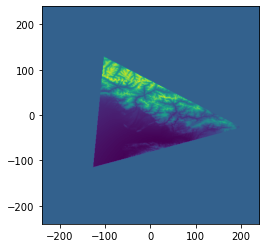

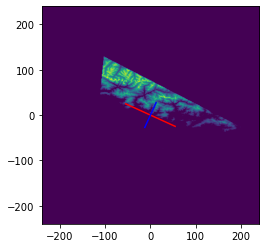

In [13]:
img = np.copy(z_masked)
y, x = np.nonzero(img)

xm = np.mean(x)
ym = np.mean(y)

x = x - xm
y = y - ym
coords = np.vstack([x, y])

# img -= img.min()
supp_img = np.copy(img)
supp_img[np.where(img < 0.0)] = 0.0
# supp_img[np.where(img > 0.0)] = 1.0
# supp_img[np.where(img < 0.0)] = img[inout][np.where(img[inout] < 0.0)].mean()
# supp_img[np.where(img > 0.0)] = img[inout][np.where(img[inout] > 0.0)].mean()
# supp_img -= supp_img.min()
cov = moments_cov(supp_img)
# img += img.min()
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]

theta = np.arctan((y_v1)/(x_v1))
print(theta / np.pi * 180)

scale = 30.0
plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
plt.show()
plt.imshow(supp_img, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.show()

#### Play with different ways of setting up the RHS for the linear regression problem.

In [14]:
import scipy.ndimage as simg

plt.figure()
z_test = np.copy(z_transformed)

# for _ in range(100):
#     z_test = np.pad(z_test,((0,0),(1,1)))
#     z_test = (z_test[:,2:] - 2.0 * z_test[:,1:-1] + z_test[:,:-2])
#     z_test = (z_test[:,1:] + z_test[:,:-1]) / 2.0
    
# z_test = simg.gaussian_filter1d(z_test,4.0,1)
# print(z_test.shape)
# z_min = z_test.min()
# z_test[np.where(z_test < 0.0)] = 0.0
# z_test -= z_min
# z_test[np.where(z_test > 0.0)] = z_test[inout_rot][np.where(z_test[inout_rot] > 0.0)].mean()
plt.imshow(z_test, origin = 'lower')
plt.show()

NameError: name 'z_transformed' is not defined

<Figure size 432x288 with 0 Axes>

#### Vectorize the selected topography and the corresponding lat,lon

In [16]:
# lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)
# lat_cell,lon_cell,z_cell = lat_mgrid[inout],lon_mgrid[inout],z[inout]

def get_IJ(lat_rot, lon_rot, z_test):
    lat_cell,lon_cell,z_cell = lat_rot[inout_rot],lon_rot[inout_rot],z_test[inout_rot]

    # now define appropriate indices for the points withing the triangle
    # by shifting the origin to the minimum lat and lon
    lat_res = lat[1] - lat[0]
    lon_res = lon[1] - lon[0]
    I = np.ceil((lat_cell - lat_cell.min())/lat_res).astype(int)
    J = np.ceil((lon_cell - lon_cell.min())/lon_res).astype(int)
    
    return I, J, lat_cell, lon_cell, z_cell

#### Niraj's Fourier routine

In [286]:
# def fitFourierSeries(data,Ni,Nj,I,J,nhar_i,nhar_j):
    # data, I, J must be in 1D
    # Ni, Nj: total number of points in i and j indices
    # nhar_i, nhar_j: number of harmonics in i and j index
    
    # number of harmonics for x,y
# m_i, n_j = range(nhar_i), range(nhar_j)

# # basis matrix
# basis_cos = []
# basis_sin = []
# for k in range(len(data)):
#     coeff_cos = [np.cos(2*np.pi*(mm*I[k]/Ni + nn*J[k]/Nj)) for mm in m_i for nn in n_j]
#     coeff_sin = [np.sin(2*np.pi*(mm*I[k]/Ni + nn*J[k]/Nj)) for mm in m_i for nn in n_j if mm!=0 or nn!=0]
#     basis_cos.append(coeff_cos)
#     basis_sin.append(coeff_sin)

# coeff = np.hstack([basis_cos,basis_sin])
# print(coeff.shape)
# tot_coeff = coeff.shape[1]
# print('Total coefficients:',tot_coeff)

# # Solve: data_k = \sum basis_kl*a_l + \epsilon
# # obtain a_l using least square minimization of the error \epsilon
# # alternative

# h_tilda_l = np.zeros((tot_coeff,))
# E_tilda_lm = np.zeros((tot_coeff,tot_coeff))

# for l in range(tot_coeff):
#     h_tilda_l[l] = np.sum(data*coeff[:,l])
#     E_tilda_lm[l,:] = np.sum(coeff*np.expand_dims(coeff[:,l], axis=1), axis=0)

# # now invert E_tilda_lm to get the coefficients
# a_m = np.linalg.inv(E_tilda_lm).dot(h_tilda_l)

# # regular FFT considers normalization by total number of datapoints N=100
# # so multiply the Fourier coefficients by N here
# a_m = a_m*len(data)

# mid = (a_m.size+1)//2
# fourier_coeff = (a_m[1:mid] + 1j*a_m[mid:])/2    # half the amplitudes are the Fourier coefficients
# fourier_coeff = np.insert(fourier_coeff,0,a_m[0])
# fourier_coeff = fourier_coeff.reshape((nhar_i,nhar_j))

# # reconstruct the dataset
# data_recons = coeff.dot(a_m)/len(data)
    
#     return fourier_coeff, data_recons

#### Setup Fourier routine

In [470]:
#---- fit the spectrum
# please note that the spectrum is sensitive to the total number of fitted
# harmonics. I did a sensitivity analysis and found that fittig 15 wavenumbers 
# works good in general
nhar_i = 12
nhar_j = 12

def prepare_terms(lat_cell, lon_cell, I, J):
    
    Ni, Nj = np.unique(lat_cell).size, np.unique(lon_cell).size

    # m_i, n_j = range(nhar_i), range(nhar_j)

    m_i = np.arange(0,nhar_i)
    # m_j = np.arange(0,nhar_j)
    if nhar_j % 2 == 0:
        m_j = np.arange(-nhar_j/2,nhar_j/2)
    else:
        m_j = np.arange(-(nhar_j-1)/2,(nhar_j)/2)
    print(m_i, len(m_i), '\n', m_j, len(m_j))

    # print(m_j[int(nhar_j/2)])
    # print(m_i, m_j)
    # print(len(m_i), len(m_j))

    term1 = m_i.reshape(1,-1) * I.reshape(-1,1) / Ni
    term2 = m_j.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    return term1, term2, Ni, Nj, m_i, m_j

def axial_f_coeffs(lat_cell, lon_cell, I, J, k_range = 1, l_range = 1, alpha = 0.0):
    
    term1, term2, Ni, Nj, m_i, m_j = prepare_terms(lat_cell, lon_cell, I, J)
    
#     c1t = np.expand_dims(term1, -1)
#     c1t = np.repeat(c1t,k_range,-1)
#     c2t = np.expand_dims(term2[:,int(nhar_j/2):int(nhar_j/2)+k_range],1)
#     c2t = np.repeat(c2t,nhar_i,1)

#     bcos = np.cos(2.0 * np.pi * (c1t + c2t))
#     bcos = bcos.reshape(bcos.shape[0],-1)

    # bcos = np.cos(2.0 * np.pi * np.hstack([term1, term2[:,int(nhar_j/2+1):]]))
    
    alpha = alpha / 180.0 * np.pi
    
    ktil = m_i * np.cos(alpha)
    ltil = m_i * np.sin(alpha)
    term1 = ktil.reshape(1,-1) * I.reshape(-1,1) / Ni + ltil.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    khat = m_j * np.cos(alpha + np.pi/2.0)
    lhat = m_j * np.sin(alpha + np.pi/2.0)
    # khat = m_j * np.cos(alpha)
    # lhat = m_j * np.sin(alpha)
    
    term2 = khat.reshape(1,-1) * I.reshape(-1,1) / Ni + lhat.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    # print(bcos.shape)
    
    bcos = 2.0 * np.cos(2.0 * np.pi * np.hstack([term1, term2[:,int(nhar_j/2+1):]]))

#     s1t = np.expand_dims(term1[:,0:0+l_range], -1)
#     s1t = np.repeat(s1t,nhar_j,-1)
#     s2t = np.expand_dims(term2,1)
#     s2t = np.repeat(s2t,l_range,1)

#     bsin = np.sin(2.0 * np.pi * (s1t + s2t))
#     bsin = bsin.reshape(bsin.shape[0],-1)

    bsin = 2.0 * np.sin(2.0 * np.pi * np.hstack([term1[:,1:], term2[:,int(nhar_j/2+1):]]))
    
    # print(bsin.shape)

    Ncos = bcos[...]
    Nsin = bsin[...]

    # Ncos = bcos[:,int(nhar_j/2):]
    # Nsin = bsin[:,int(nhar_j/2+1):]
    
    # print(term2[:,int(nhar_j/2):int(nhar_j/2)+k_range])
    # print(term1[:,1:1+l_range])

    # print(Ncos.shape)
    # print(Nsin.shape)
    
    return Ncos, Nsin

def full_f_coeffs(lat_cell, lon_cell, I, J):
    
    term1, term2, Ni, Nj, m_i, m_j = prepare_terms(lat_cell, lon_cell, I, J)
    
    term1 = np.expand_dims(term1,-1)
    term1 = np.repeat(term1,nhar_j,-1)
    term2 = np.expand_dims(term2,1)
    term2 = np.repeat(term2,nhar_i,1)
    
    # print(term1.shape)

    tt_sum = term1 + term2
    tt_sum = tt_sum.reshape(tt_sum.shape[0],-1)

    # print(term2[:,int(nhar_j/2)].reshape(-1,1))
    # bcos = np.cos(2.0 * np.pi * (term1 + term2[:,:int(nhar_j/2)].reshape(-1,1)))
    # bsin = np.sin(2.0 * np.pi * (term1[:,1].reshape(-1,1) + term2))

    bcos = np.cos(2.0 * np.pi * (tt_sum))
    bsin = np.sin(2.0 * np.pi * (tt_sum))
    # bsin = np.sin(2.0 * np.pi * (tt_sum[:,1:]))

#     i_chk = np.repeat(np.expand_dims(m_i,0),len(I),0)
#     j_chk = np.repeat(np.expand_dims(m_j,0),len(J),0)

#     i_chk = np.expand_dims(i_chk,-1)
#     j_chk = np.expand_dims(j_chk,1)

#     i_chk = np.repeat(i_chk,nhar_j,-1)
#     j_chk = np.repeat(j_chk,nhar_i,1)

#     Ncos = tt_sum[~((i_chk == 0) & (j_chk < 0.))]
#     Ncos = np.cos( 2.0 * np.pi * bcos.reshape(len(I),int((nhar_i * nhar_j - nhar_j/2))) )

#     Nsin = tt_sum[~((i_chk == 0) & (j_chk <= 0.))]
#     Nsin = np.sin( 2.0 * np.pi * bsin.reshape(len(J),int((nhar_i * nhar_j - nhar_j/2 - 1))) )

    Ncos = bcos[:,int(nhar_j/2):]
    Nsin = bsin[:,int(nhar_j/2+1):]

    print(Ncos.shape)
    print(Nsin.shape)
    
    return Ncos, Nsin

#### Stack Fourier terms and invert E_tilda_lm to get the coefficients

In [472]:
def get_recon(Ncos, Nsin, data, typ='full'):
    coeff = np.hstack([Ncos,Nsin])
    # print(coeff.shape)
    tot_coeff = coeff.shape[1]
    # print('Total coefficients:',tot_coeff)

    E_tilda_lm = np.zeros((tot_coeff,tot_coeff))
    h_tilda_l = (data.reshape(-1,1) * coeff).sum(axis=0)

    for k in range(0,len(data)):
        E_tilda_lm += np.expand_dims(coeff[k],-1) * np.expand_dims(coeff[k],0)

    import scipy.linalg as la

    a_m = la.inv(E_tilda_lm).dot(h_tilda_l)

    # regular FFT considers normalization by total nu  mber of datapoints N=100
    # so multiply the Fourier coefficients by N here
    a_m = a_m*len(data)

    fourier_coeff = np.zeros((nhar_i, nhar_j))
    nc = Ncos.shape[1]
    
    
    zrs = np.zeros((int(nhar_j/2)))
    # coeffs = np.concatenate((zrs,coeffs))
    
    if typ == 'full':
        f00 = a_m[0]
        cos_terms = a_m[:nc]
        sin_terms = a_m[nc:]
        cos_terms = np.concatenate((zrs,cos_terms))
        sin_terms = np.concatenate((zrs,[f00],sin_terms))
        print(cos_terms.shape, sin_terms.shape)
        
        fourier_coeff = cos_terms + 1.0j * sin_terms
        fourier_coeff = fourier_coeff.reshape(nhar_i,nhar_j)
        fourier_coeff = fourier_coeff.T
        
    if typ == 'axial':
        f00 = a_m[0]
        cos_terms = a_m[1:nc]
        sin_terms = a_m[nc:]
        y_axs = cos_terms[:int(nhar_j/2-1)] + 1.0j * sin_terms[:int(nhar_j/2-1)]
        # y_axs = y_axs.reshape(1,-1)
        x_axs = cos_terms[int(nhar_j/2-1):] + 1.0j * sin_terms[int(nhar_j/2-1):]
        x_axs = x_axs.reshape(-1,1)
        l_blk = np.zeros(( int(nhar_i-1), int(nhar_j/2-1) ))
        u_blk = np.zeros(( int(nhar_i-1), int(nhar_j/2) ))
        # print(x_axs.shape, y_axs.shape)
        
        # print(l_blk.shape, u_blk.shape)
        
        r1 = np.hstack(([0]*int(nhar_j/2),[f00],y_axs)).reshape(1,-1)
        # print(r1.shape)
        r2 = np.hstack((u_blk,x_axs,l_blk))
        # print(r2.shape)
        fourier_coeff = np.vstack((r1,r2))
        fourier_coeff = fourier_coeff.T
        
        
        
        # x_axs = cos_terms[]
        # y_axs = 1.j * a_m[1:int(nhar_j/2-1+1)]
        # x_axs = a_m[nc : int(nc + nhar_i - 1)]
        # lower_quad = a_m[int(nhar_j/2+1) : int(nhar_j/2+1) + int((nhar_j/2) * (nhar_i-1))] + 1.j * a_m[int(nc + nhar_j/2) : int(nc + nhar_j/2) + int((nhar_j/2) * (nhar_i-1))]
        # upper_qaud = 
        
        # print("x_axs =", x_axs.size)
        # print("y_axs =", y_axs.size)
        # print("lquad =", lower_quad.size)
        # print("uquad =", upper_quad.size)
    # mid = (a_m.size+1)//2
    # fourier_coeff = (a_m[1:mid] + 1j*a_m[mid:])/2    # half the amplitudes are the Fourier coefficients
    # fourier_coeff = np.insert(fourier_coeff,0,a_m[0])
    # fourier_coeff = fourier_coeff.reshape((nhar_i,nhar_j))
    
    # reconstruct the dataset
    data_recons = coeff.dot(a_m)/len(data)

    recons_z = data_recons
    
    return recons_z, fourier_coeff

#### Reshape the reconstructed topography to the trianglular form

In [473]:
def recon_2D(recons_z, z, inout_rot):
    recons_z_2D = np.zeros(np.shape(z))
    c = 0
    for i in range(len(lat)):
        for j in range(len(lon)):
    #         if (inout[i,j] == 1):
    #             recons_z_2D[i,j] = recons_z[c]
    #             c = c+1

            if (inout_rot[i,j] == 1):
                recons_z_2D[i,j] = recons_z[c]
                c = c+1
                
    return recons_z_2D

# print(c)

theta in degrees: 0.0
[ 0  1  2  3  4  5  6  7  8  9 10 11] 12 
 [-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.] 12
(38331, 138)
(38331, 137)
(144,) (144,)


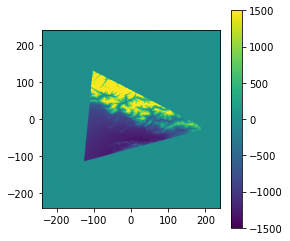

56625.01067189265


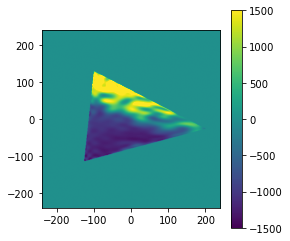

In [492]:
plot_diag = False

x_v1, x_v2, y_v1, y_v2 = get_pca(z_masked, plot_diag = plot_diag)

theta = (90-24.488095787517768) / 180.0 * np.pi
theta = 21.0 / 180.0 * np.pi
theta = None
z_transformed, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, z_masked, theta=0.0, plot_diag = plot_diag, verbose = True)

Ncells_in_triangle = np.sum(inout_rot)
I, J, lat_cell, lon_cell, z_cell = get_IJ(lat_rot, lon_rot, z_masked)

Ncos, Nsin = full_f_coeffs(lat_cell, lon_cell, I, J)
recons_z, fourier_coeffs = get_recon(Ncos, Nsin, z_cell)

# Ncos, Nsin = axial_f_coeffs(lat_cell, lon_cell, I, J, alpha=0.0)
# recons_z, fourier_coeffs = get_recon(Ncos, Nsin, z_cell, typ='axial')

recons_z_2D = recon_2D(recons_z, z_masked, inout_rot)
# mtheta = None if theta is None else -theta
# mtheta = 0
# recons_z_rot, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, recons_z_2D, mtheta)
# z_orig, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, z_transformed, mtheta)

# print(np.linalg.norm(recons_z_rot - z_orig))

lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)

plt.figure(figsize=fs)
plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
plt.colorbar()
plt.show()

# plt.figure(figsize=fs)
# plt.imshow(inout_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(lat_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(lon_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(recons_z_2D, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# plt.colorbar()
# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(z_orig, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# plt.colorbar()
# plt.show()
# plt.figure(figsize=fs)
# plt.imshow(recons_z_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# plt.colorbar()
# plt.show()
plt.figure(figsize=fs)
plt.imshow(recons_z_2D, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
plt.colorbar()

# scale = 30.0
# plt.plot([x_v1*-scale*2, x_v1*scale*2],
#          [y_v1*-scale*2, y_v1*scale*2], color='red')
# plt.plot([x_v2*-scale, x_v2*scale],
#          [y_v2*-scale, y_v2*scale], color='blue')
# plt.show()

print(np.linalg.norm(recons_z_2D - z_masked))

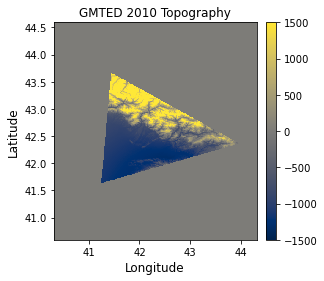

In [487]:
fs = (4,4)
plt.figure(figsize=fs)
# im = plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin, cmap='cividis')
im = plt.pcolormesh(lon_mgrid, lat_mgrid, z_masked, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
plt.colorbar(im,fraction=0.05, pad=0.04)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('GMTED 2010 Topography')
plt.savefig('gmted.pdf', bbox_inches='tight', dpi=1200)
plt.show()

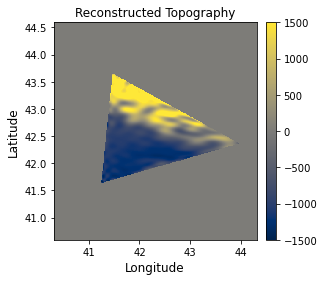

In [493]:
fs = (4,4)
plt.figure(figsize=fs)
# im = plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin, cmap='cividis')
im = plt.pcolormesh(lon_mgrid, lat_mgrid, recons_z_2D, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
plt.colorbar(im,fraction=0.05, pad=0.04)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Reconstructed Topography')
plt.savefig('full_recons.pdf', bbox_inches='tight', dpi=1200)
plt.show()

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5]


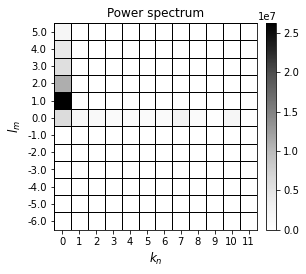

In [477]:
fs = (4,3.8)
plt.figure(figsize=fs)

im = plt.pcolormesh(np.abs(fourier_coeffs), edgecolors='k', cmap='Greys')
plt.colorbar(im,fraction=0.05, pad=0.04)
if nhar_j % 2 == 0:
    m_j = np.arange(-nhar_j/2,nhar_j/2)
else:
    m_j = np.arange(-(nhar_j-1)/2,(nhar_j)/2)
    
ylocs = np.arange(.5,12.5,1.0)
# ylocs = np.arange(0,12)
print(ylocs)
plt.yticks(ylocs, m_j)
plt.xticks(ylocs, np.arange(0,12))
plt.title("Power spectrum")
plt.xlabel(r'$k_n$', fontsize=12)
plt.ylabel(r'$l_m$', fontsize=12)
# plt.grid()
plt.savefig('axial_coeffs_rot.pdf', bbox_inches='tight')
plt.show()

In [293]:
x_v1, x_v2, y_v1, y_v2 = get_pca(z_masked)

xs = np.arange(400,550)/10.0
theta_range = xs / 180.0 * np.pi
xs = np.arange(0,91,1)
theta_range = xs #/ 180.0 * np.pi
# theta_range = [1.0 / 180.0 * np.pi]
errs = []
Erot = []
Etot = []
Enai = []
Eful = []

z_transformed, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, z_masked, 0.0, verbose=True)
I, J, lat_cell, lon_cell, z_cell = get_IJ(lat_rot, lon_rot, z_transformed)

for theta in theta_range:
    print("theta in degrees = %.3f" %theta, end='\r')
    Ncos, Nsin = axial_f_coeffs(lat_cell, lon_cell, I, J, alpha=theta)
    recons_z,_ = get_recon(Ncos, Nsin, z_cell, typ='axial')
    recons_z_2D = recon_2D(recons_z, z_transformed, inout_rot)
    # recons_z_rot, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, recons_z_2D, -theta)
    # z_orig, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, z_transformed, -theta)
    
#     plt.figure()
#     plt.imshow(z_orig, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
#     plt.colorbar()
#     plt.show()
#     plt.figure()
#     plt.imshow(recons_z_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
#     plt.colorbar()
#     plt.show()

#     print(np.linalg.norm(recons_z_rot - z_orig))
#     print(np.linalg.norm(z_orig - z_masked))

#     errs.append(np.linalg.norm(recons_z_2D - z_transformed))
#     errs.append(np.linalg.norm(recons_z_rot - z_orig) - np.linalg.norm(z_orig - z_masked))
    # Erot.append(np.linalg.norm(z_orig - z_masked))
    # Etot.append(np.linalg.norm(recons_z_rot - z_masked))
    Enai.append(np.linalg.norm(recons_z_2D - z_transformed))
    # Eful.append(np.linalg.norm(recons_z_rot - z_masked))
#     errs.append(np.linalg.norm((recons_z_rot - z_masked) - (z_orig - z_masked)))
    

theta in degrees: 0.0


In [294]:
Erot = np.array(Erot)
Etot = np.array(Etot)
Enai = np.array(Enai)
Eful = np.array(Eful)

21.5841711823101
21


<Figure size 432x288 with 0 Axes>

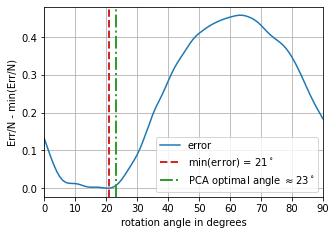

In [482]:
errs = np.array(errs)

xs = np.arange(0,91,1)
plt.figure()
# plt.plot(xs, errs / Ncells_in_triangle)
# plt.plot(xs, errs)
# NN = 480.0*480.0
# Er = Erot / Erot.max()
# Et = Etot / NN
# En = (Enai - Enai.min())
# En /= En.max()
# Ef = (Eful - Eful.min())
# Ef /= Ef.max()
err = Enai / Ncells_in_triangle
err_min = err.min()
err -= err.min()
print(err.max()/err_min*100.0)

plt.figure(figsize=(5,3.5))
plt.plot(xs, err, label="error", c='C0')
# plt.plot(xs, Et-Et.min(), label="Etot")
# plt.plot(xs, En, label="Error (z_recon - z_rot)")
# plt.plot(xs, Ef, label="Error (z_rerot - z_masked)")

# plt.plot(xs, (Etot - Etot.min()) - (Erot - Erot.min()))
# EAmp = En.max() - En.min()
# ER = (Er - Er.mean() * Er)
# ER /= ER.max()
# ET = Et - Et.min()
# ET /= ET.max()

# plt.plot(xs, Er + En, label='ER')
# plt.plot(xs, ET, label='ET')
# plt.plot(xs, ET - ER)

print(np.argmin(Enai))

plt.axvline(np.argmin(Enai), c='C3', ls='--', lw=2.0, label=r'min(error) = $21^\circ$')
# plt.axvline(6.3, c='k', ls='--', lw=0.6)
plt.axvline(23.0, c='C2', ls='dashdot', lw=2.0, label=r'PCA optimal angle $\approx 23^\circ$')
xlbl = np.arange(0,91,10)
# plt.xlabel(xlbl,xlbl)
plt.xticks(xlbl)
# plt.axvline(53.1, c='k', ls='--', lw=0.6)
# plt.axvline(45, c='k')
# plt.axvline(46.7+90, c='k')
# plt.axvline(46.7+180, c='k')
# plt.title(r'$E_{\rm{rot}}$')
plt.legend(loc='lower right')
plt.xlabel("rotation angle in degrees")
plt.ylabel("Err/N - min(Err/N)")
plt.xlim([0.0,90.0])
plt.grid()
plt.savefig('err_plot.pdf',bbox_inches='tight')
plt.show()

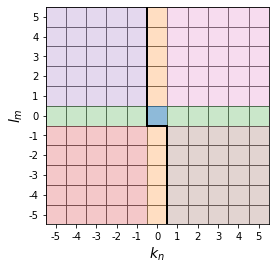

In [478]:
from matplotlib.patches import Rectangle

base = np.zeros((11,11))

origin = Rectangle((5,5),1,1,linewidth=1,facecolor='C0',alpha=0.5)
vax0 = Rectangle((5,0),1,5,linewidth=1,facecolor='C1',alpha=0.25)
vax1 = Rectangle((5,6),1,5,linewidth=1,facecolor='C1',alpha=0.25)
hax0 = Rectangle((0,5),5,1,linewidth=1,facecolor='C2',alpha=0.25)
hax1 = Rectangle((6,5),5,1,linewidth=1,facecolor='C2',alpha=0.25)

llq = Rectangle((0,0),5,5,linewidth=1,facecolor='C3',alpha=0.25)
ulq = Rectangle((0,6),5,5,linewidth=1,facecolor='C4',alpha=0.25)
lrq = Rectangle((6,0),5,5,linewidth=1,facecolor='C5',alpha=0.25)
urq = Rectangle((6,6),5,5,linewidth=1,facecolor='C6',alpha=0.25)

plt.figure(figsize=(4,4))
# plt.axhline(5.5,c='k',lw=2.0, alpha=0.75)
# plt.axvline(5.5,c='k',lw=2.0, alpha=0.75)
plt.pcolormesh(base, edgecolors='k', cmap='Greys',alpha=0.5)
ax = plt.gca()
ax.add_patch(origin)
ax.add_patch(vax0)
ax.add_patch(vax1)
ax.add_patch(hax0)
ax.add_patch(hax1)

ax.add_patch(llq)
ax.add_patch(ulq)
ax.add_patch(lrq)
ax.add_patch(urq)

plt.plot((5.0,5.0),(5.0,11.0),'k',lw=2)
plt.plot((5.0,6.0),(5.0,5.0),'k',lw=2)
plt.plot((6.0,6.0),(0.0,5.0),'k',lw=2)

midpts = np.arange(0.5,11.5)
lbls = np.arange(-5,6)
plt.xticks(midpts,lbls)
plt.yticks(midpts,lbls)
plt.xlabel(r'$k_n$', fontsize=14)
plt.ylabel(r'$l_m$', fontsize=14)
plt.savefig('re_im.pdf',bbox_inches='tight')
plt.show()


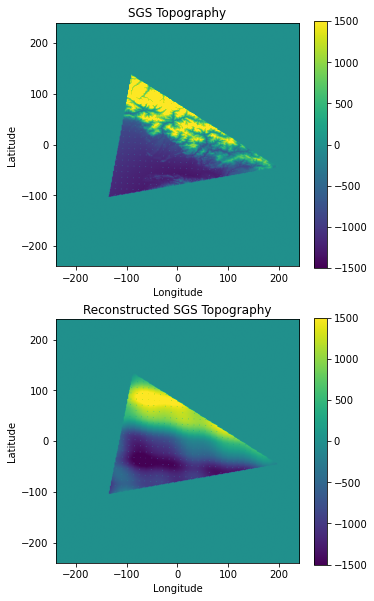

In [697]:
#---- plot the topography and the spectrum
fig = plt.figure(figsize=(12,10))
# plot the topography within the cell
ax1 = fig.add_subplot(221)
# always use pcolormesh for plotting data with fine structures
sp1 = ax1.imshow(z_transformed, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# draw the cell
# x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
# y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
# ax1.plot(x,y,'-r')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('SGS Topography')
fig.colorbar(sp1,ax=ax1)

# plot the reconstructed data
ax3 = fig.add_subplot(223)
sp3 = ax3.imshow(recons_z_2D, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# plt.plot(x,y,'-r')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Reconstructed SGS Topography')
fig.colorbar(sp3)
plt.show()
fig.savefig('SGS_spectrum_recons_andes.jpeg',dpi=300)

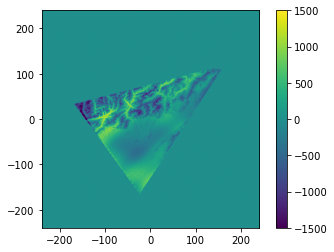

90674.4985885701


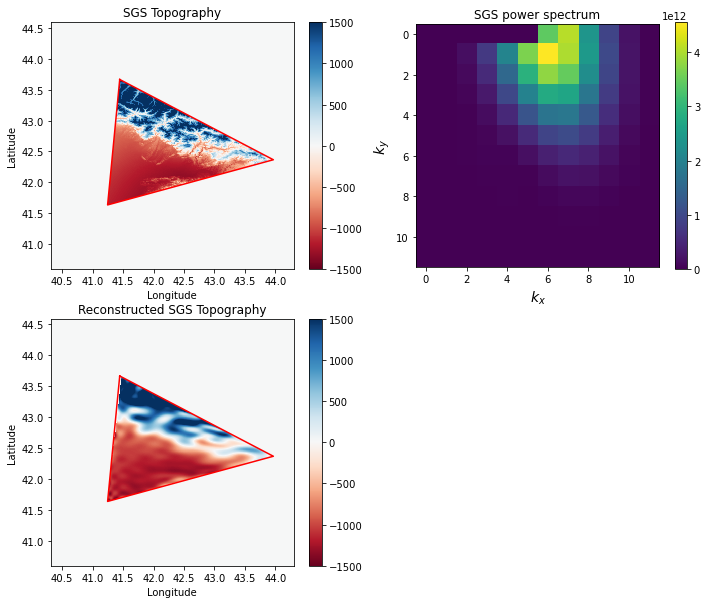

In [145]:
#---- plot the topography and the spectrum
fig = plt.figure(figsize=(12,10))
vmin=-1500; vmax=1500
# plot the topography within the cell
ax1 = fig.add_subplot(221)
# always use pcolormesh for plotting data with fine structures
sp1 = ax1.pcolormesh(lon_mgrid,lat_mgrid,z_masked,
                     vmin=vmin,vmax=vmax,cmap=mpl.cm.RdBu,shading='auto')
# draw the cell
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
ax1.plot(x,y,'-r')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('SGS Topography')
fig.colorbar(sp1,ax=ax1)

# plot the spectrum -- Approach 1
# ax2 = fig.add_subplot(222)
# sp2 = plt.contourf(np.abs(spec),60)
# sp2 = plt.contourf(fourier_coeff1.real,60)
# ax2.set_xlabel(r'$k_x$',fontsize=14)
# ax2.set_ylabel(r'$k_y$',fontsize=14)
# ax2.set_title('SGS Spectrum (Approach 1)')
# cmap = mpl.cm.viridis
# norm = mpl.colors.Normalize(vmin=-10,vmax=10)
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap))
# plt.colorbar()

# plot the spectrum -- Approach 2
ax2 = fig.add_subplot(222)
sp2 = ax2.imshow(np.abs(fourier_coeffs))
fig.colorbar(sp2,ax=ax2)
ax2.set_xlabel(r'$k_x$',fontsize=14)
ax2.set_ylabel(r'$k_y$',fontsize=14)
ax2.set_title('SGS power spectrum')

# plot the reconstructed data
ax3 = fig.add_subplot(223)
sp3 = ax3.pcolormesh(lon_mgrid,lat_mgrid,recons_z_2D,
                     cmap=mpl.cm.RdBu,vmin=vmin,vmax=vmax,shading='auto')
plt.plot(x,y,'-r')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Reconstructed SGS Topography')
fig.colorbar(sp3)
plt.show()
fig.savefig('SGS_spectrum_recons_andes.jpeg',dpi=300)

In [ ]:
ZZ = np.load('z.npy')

In [ ]:
print(ZZ.shape)
print(recons_z_2D.shape)
plt.figure()
plt.imshow(ZZ)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(recons_z_2D)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(ZZ-recons_z_2D)
plt.colorbar()
plt.show()

print(la.norm(ZZ-z_masked)) #/ sum(z_masked))
print(la.norm(recons_z_2D-z_masked))# / sum(z_masked))